### Esame di Analisi Dati in Fisica Subnucleare del 14 luglio 2023. Tema: Programmazione in Python
# Studio della radiazione Cherenkov in acqua

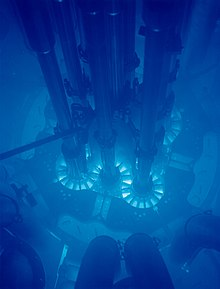

## Introduzione
In questo esercizio studieremo la radiazione Cherenkov emessa da protoni ed elettroni che attraversano un volume d'acqua.
Prima studieremo la simulazione della radiazione Cherenkov e poi studieremo come le particelle rallentano per perdita di energia per ionizzazione e come tenere conto di questo effetto nel conteggio del numero di fotoni Cherenkov emessi.

## Librerie utilizzate
Per questo esercizio si richiede competenza principalmente su `numpy` e `matplotlib`. Useremo `pandas` per caricare le parametrizzazioni necessarie da database esterni, in cui sono ottenute da modelli fenomenologici e fit sui dati.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Emissione della luce Cherenkov

Lo spettro di emissione della luce Cherenkov, espresso in funzione della lunghezza d'onda $\lambda$, dovuto al passaggio di una particella che attraversa con velocità $\beta c$ uno strato di spessore infinitesimo $dx$ di un mezzo con indice di rifrazione $n(\lambda)$ è data da
$$
\frac{d^2N}{dxd\lambda} =
\frac{2\pi\alpha z^2}{\lambda^2}\left(1- \frac{1}{\beta^2n^2(\lambda)}\right)
$$

dove $\alpha \simeq \frac{1}{137}$ è la costante di struttura fine e $z$ è la carica della particella in unità della carica fondamentale (e dunque $z^2 = 1$ per elettrone e protone).

Per ottenere lo spettro di emissione, occorre dunque conoscere l'evoluzione dell'indice di rifrazione $n$ in funzione della lunghezza d'onda.

Il blocco di codice successivo consente di ottenere dal sito `refractiveindex.info` due tabelle, nella forma di pandas DataFrame che definiscono, per punti, la parte reale ($n$) e la parte immaginaria ($k$) dell'indice di rifrazione in acqua in funzione della lunghezza d'onda $\lambda$.

In [ ]:
import requests
from io import StringIO

def read_refractivedex_info(url):
  response = requests.get(url)

  tab_n = []; tab_k = []
  output = None
  for line in response.text.split('\n'):
    if "wl,n" in line: output=tab_n
    elif "wl,k" in line: output=tab_k
    output.append(line)

  return (
      pd.read_csv(StringIO("\n".join(tab_n))),
      pd.read_csv(StringIO("\n".join(tab_k))),
  )


n, k = read_refractivedex_info("https://refractiveindex.info/data_csv.php?datafile=database/data-nk/main/H2O/Segelstein.yml")

## Parte 1
### Esercizio 1.1

Costruire il grafico di $n$ e $k$ in funzione della lunghezza d'onda.

Il grafico dovrebbe assomigliare al seguente.

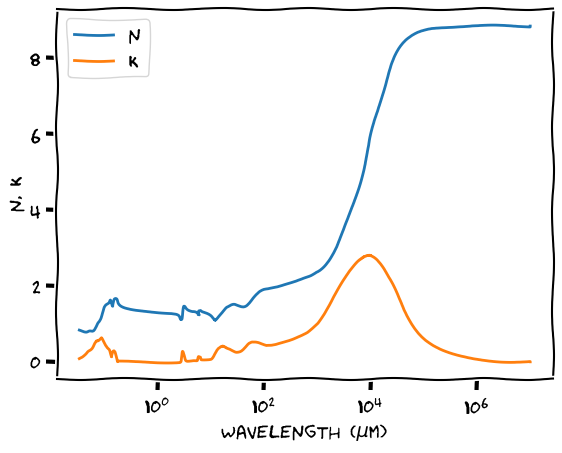

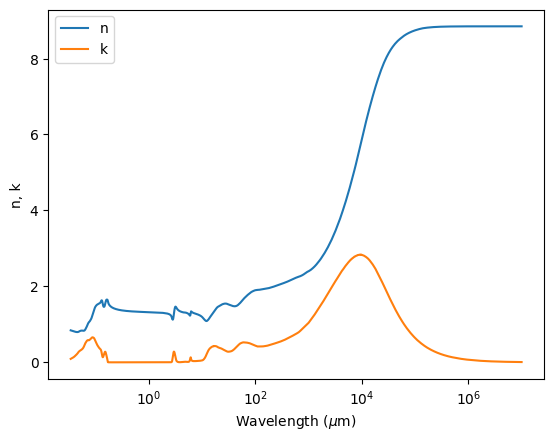

In [ ]:
## Soluzione
plt.plot(n.wl, n.n, '-', label='n')
plt.plot(k.wl, k.k, '-', label='k')
plt.legend()
plt.xlabel("Wavelength ($\mu$m)")
plt.ylabel("n, k")
plt.xscale('log')
plt.show()

### Esercizio 1.2

Ai fini di questo esercizio, è interessante soprattutto la parte di spettro nel visibile o nel vicinon infrarosso.

Rappresentare la curva nell'intervallo $\lambda \in [0, 700]$ nm.

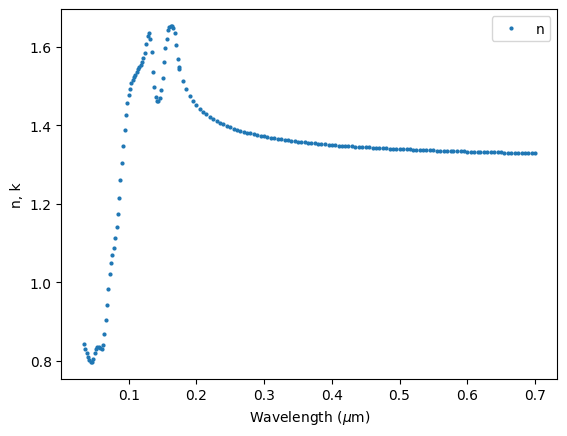

In [ ]:
# Soluzione
vis_n = n.query("wl < 0.7")
vis_k = k.query("wl < 0.7")

plt.plot(vis_n.wl, vis_n.n, 'o', label='n', markersize=2)
plt.legend()
plt.xlabel("Wavelength ($\mu$m)")
plt.ylabel("n, k")
plt.show()

### Esercizio 1.3

Per poter utilizzare la serie di punti mostrata sopra come una funzione, possiamo definire una funzione per punti usando la funzione [`np.interp`](https://numpy.org/doc/stable/reference/generated/numpy.interp.html).

Per esempio
```python
# Define a function returning n as a function of the wavelength
def get_n (wavelen):
  return np.interp(<your code here>)

# Define the axis of the wavelengths
wavelen_axis = np.linspace(0.04, 0.7, 100)

# Evaluate the function defined above on the axis
n = get_n(wavelen_axis)
```

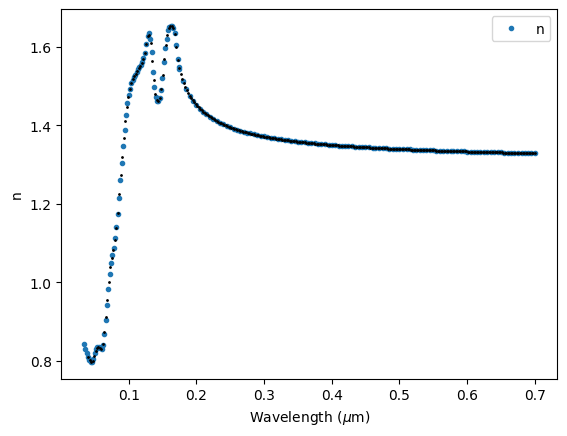

In [ ]:
## Soluzione

def get_n (wl):
  return np.interp(wl, n.wl, n.n)

wl = np.linspace(0.04, 0.7, 300)
plt.plot(vis_n.wl, vis_n.n, 'o', label='n', markersize=3)
plt.plot(wl, get_n(wl), 'k.', markersize=2)
plt.legend()
plt.xlabel("Wavelength ($\mu$m)")
plt.ylabel("n")
plt.show()

### Esercizio 1.4
Per poter osservare i fotoni emessi dalla particella, occorre che questi ultimi si possano propagare nel mezzo (in questo caso l'acqua) senza essere immediatamente assorbiti.
L'acqua modifica il suo coefficiente di assorbimento $k$ in modo piuttosto repentino tra i 150 e i 200 nm. Al di sopra della soglia l'acqua è trasparente, al di sotto è opaca.

Per determinare la soglia in modo più preciso, si studi la dipendenza di $k(\lambda)$ e si ponga la soglia, per esempio, scegliendola pari alla lunghezza d'onda più piccola per cui $k(\lambda) < 10^{-6}$.



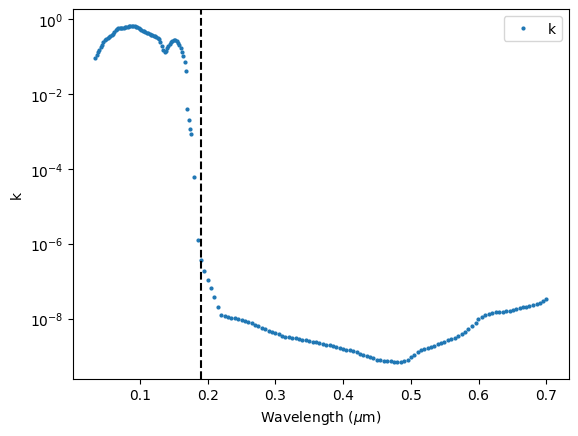

In [ ]:
## Soluzione
plt.plot(vis_k.wl, vis_k.k, 'o', label='k', markersize=2)
plt.yscale('log')

wlen_min = np.min(vis_k.query('k<1e-6').wl)
ylim = plt.ylim()
plt.plot([wlen_min]*2, ylim, 'k--')
plt.ylim(ylim)
plt.legend()
plt.xlabel("Wavelength ($\mu$m)")
plt.ylabel("k")
plt.show()

## Parte 2

Nel blocco di codice qui sotto, è implementata la funzione che implementa la formula dello spettro Cherenkov
$$
\frac{d^2N}{dxd\lambda} =
\frac{2\pi\alpha z^2}{\lambda^2}\left(1- \frac{1}{\beta^2n^2(\lambda)}\right)
$$

> **Curiosità.** Questa implementazione prevede che la funzione possa essere valutata su un array di valori $\beta$ in una sola chiamata, velocizzando molto parti successive dell'esercizio.


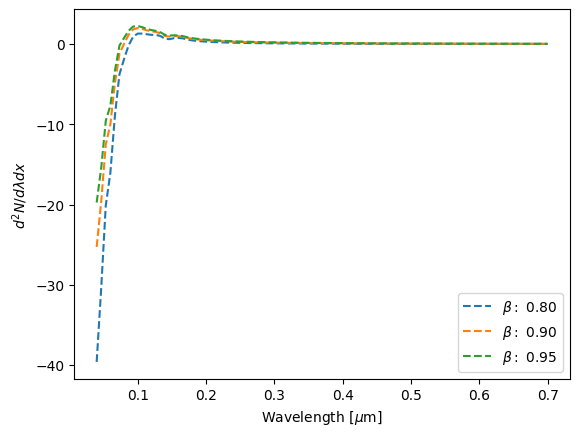

In [ ]:
## Define the wavelength axis
wavelen_axis = np.linspace(0.04, 0.7, 100)

## Define some values for which we want to compute the dndwl.
beta = np.array([0.8, 0.9, 0.95])

## Define the function
dndwl = 2*np.pi/137/wavelen_axis**2 * (1 - 1/(beta[:,None]*get_n(wavelen_axis))**2)

## Plotting
for beta_value, dndwl_row in zip(beta, dndwl):
  plt.plot(wavelen_axis, dndwl_row, '--', label=f'$\\beta:$ {beta_value:.2f}')

plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("$d^2N/d\lambda dx$")
plt.legend()
plt.show()

### Esercizio 2.1
L'implementazione della funzione riportata sopra è chiaramente problematica.
Cosa dovrebbe voler indicare l'emissione di un numero negativo di fotoni?

Correggere la funzione in modo tale che i valori negativi vengano sostituiti con zero.

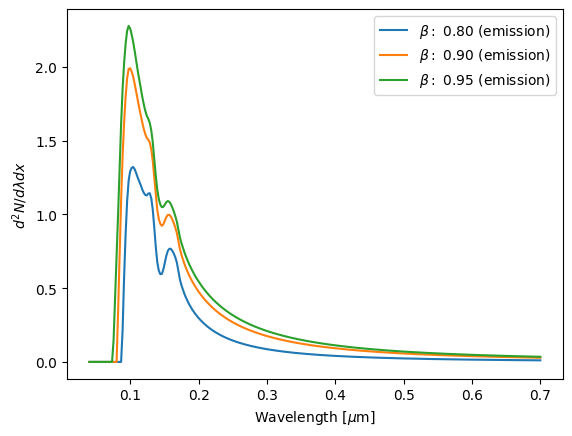

In [ ]:
## Soluzione
beta = np.array([0.8, 0.9, 0.95])
dndwl = np.maximum(0, 2*np.pi/137/wl**2 * (1 - 1/(beta[:,None]*get_n(wl))**2))

for beta_value, dndwl_row in zip(beta, dndwl):
  plt.plot(wl, dndwl_row, '-', label=f'$\\beta:$ {beta_value:.2f} (emission)')

plt.legend()

plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("$d^2N/d\lambda dx$")
plt.show()

## Esercizio 2.2
Ora, dobbiamo correggere per gli effetti di autoassorbimento.

Usando la soglia determinata nell'esercizio 1.4, si ponga a zero la parte dello spettro per cui l'acqua risulta opaca.

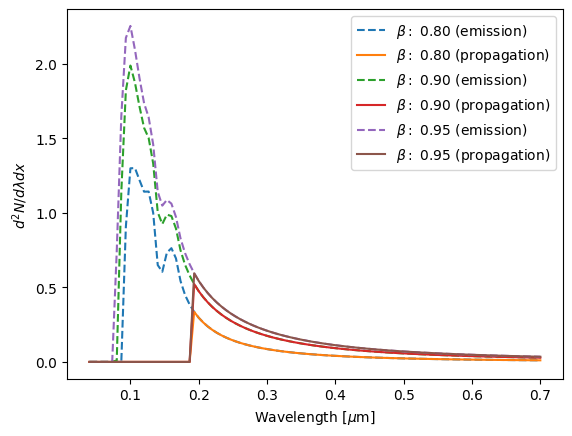

In [ ]:
## Soluzione
beta = np.array([0.8, 0.9, 0.95])
dndwl = np.maximum(0, 2*np.pi/137/wavelen_axis**2 * (1 - 1/(beta[:,None]*get_n(wavelen_axis))**2))
dndwlT = np.where (wavelen_axis < wlen_min, 0, dndwl)

for beta_value, dndwl_row, dndwlT_row in zip(beta, dndwl, dndwlT):
  plt.plot(wavelen_axis, dndwl_row, '--', label=f'$\\beta:$ {beta_value:.2f} (emission)')
  plt.plot(wavelen_axis, dndwlT_row, '-', label=f'$\\beta:$ {beta_value:.2f} (propagation)')

plt.legend()

plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("$d^2N/d\lambda dx$")
plt.show()

### Esercizio 2.3

Dallo spettro di emissione, corretto per gli effetti di trasmissione, possiamo ottenere una stima nel numero di fotoni Cherenkov trasmessi in acqua per unità di spessore attraversato.

$$
\frac{dN_\mathrm{tr}}{dx} = \int_0^{+\infty}\frac{dN^2_{\mathrm{tr}}}{dxd\lambda} d\lambda
$$

Definire la funzione `count_photons_per_micron(beta)` che prenda in input un array di valori per la velocità $\beta$ e restituisca il numero di fotoni emesso per ciascun valore di $\beta$ nell'array.

> **Suggerimento.** Per integrare la funzione ottenuta nell'esercizio 2.2, si veda la funzione di numpy [`np.trapz`](https://numpy.org/doc/stable/reference/generated/numpy.trapz.html).

```python
def count_photons_per_micron(beta):
  ## Define some values for which we want to compute the dndwl.
  wavelen_axis = np.linspace(0.1, 1., 91)

  ## Define the function
  dndwl = 2*np.pi/137/wl**2 * (1 - 1/(beta[:,None]*get_n(wavelen_axis))**2)

  ## Apply the corrections for water opacity and non-negative emission
  dndwl_corr = ...

  return np.trapz(...)
```

In [ ]:
## Soluzione

def count_photons_per_micron (beta):
  wl = np.linspace(0.1, 1., 91)
  dndwl = np.maximum(0, 2*np.pi/137/wl**2 * (1 - 1/(beta[:,None]*get_n(wl))**2))
  dndwlT = np.where (wl < wlen_min, 0, dndwl)
  return np.trapz(dndwl, x=wl)

## Esercizio 2.4

Possiamo ora mostrare in grafico il numero di fotoni attesi per micron per elettroni e protoni in acqua.

1. Definire l'intervallo d'impulso, per esempio $p \in [0.1\ \mathrm{MeV}/c,  5
\ \mathrm{GeV}/c]$
2. Calcolare $\beta$ per protoni ($m_p \sim 938 \mathrm{MeV}/c^2$) ed elettorni($m_e \sim 0.511 \mathrm{MeV}/c^2$)
3. Costruire il plot.

Dovrebbe assomigliare al seguente.

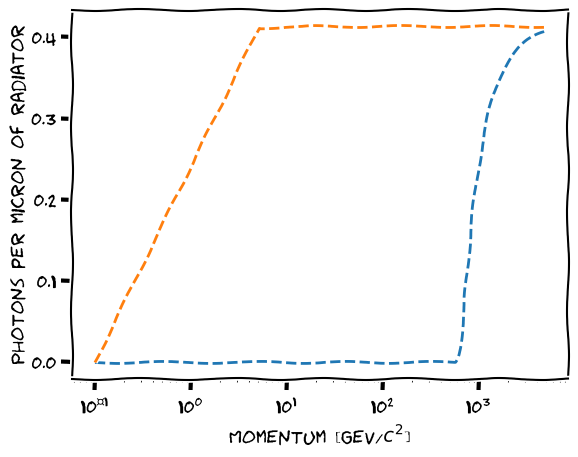

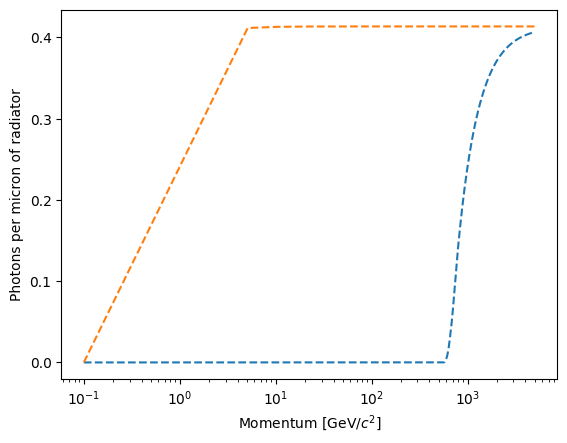

In [ ]:
# Soluzione

p = np.linspace(0.1, 5000, 1001)
beta_proton = p/938
beta_electron = p/0.511

plt.plot(p, count_photons_per_micron(beta_proton), '--', label="Proton")
plt.plot(p, count_photons_per_micron(beta_electron), '--', label="Electron")
plt.xlabel("Momentum [GeV/$c^2$]")
plt.ylabel("Photons per micron of radiator")
plt.xscale('log')
plt.show()

## Parte 3
Ora che abbiamo un modello per l'emissione di luce Cherenkov dobbiamo combinarlo con un modello per la perdita di energia per ionizzazione.
Infatti una particella che viaggia in acqua perderà energia e di conseguenza ridurrà la sua velocità e modificherà l'emissione Cherenkov.

Per modellare la perdita di energia in acqua, usiamo nuovamente dei dati tabulati che combinano il modello di Bethe block con modelli fenomenologici adattati in base ai dati sperimentali per la parte a bassissima quantità di moto.

Il blocco di codice sotto serve per scaricare i dati.

In [ ]:
pstar_db = pd.read_csv("https://pandora.infn.it/public/31d7c4/dl/proton_in_water_dEdx.csv")
estar_db = pd.read_csv("https://pandora.infn.it/public/796c6b/dl/electrons_in_water_dEdx.csv")

def get_dedx_electron (Ek):
  return np.interp(Ek, estar_db.Ek, estar_db.dedx)

def get_dedx_proton (Ek):
  return np.interp(Ek, pstar_db.Ek, pstar_db.dedx)

Le serie ottenute sono visualizzate nel grafico qui sotto.

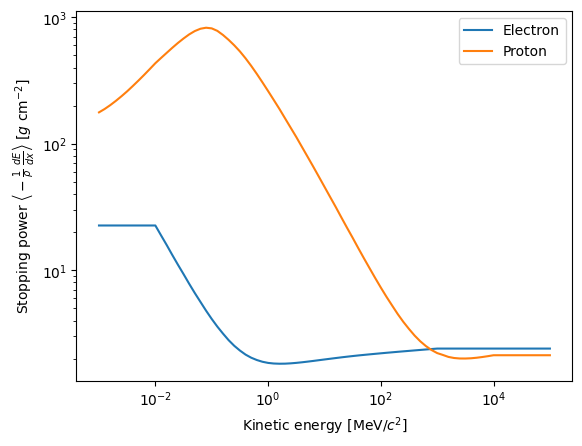

In [ ]:
Ek = 10**np.linspace(-3, 5, 81)
plt.plot(Ek, get_dedx_electron(Ek), label="Electron")
plt.plot(Ek, get_dedx_proton(Ek), label="Proton")
plt.xlabel("Kinetic energy [MeV/$c^2$]")
plt.ylabel(r"Stopping power $\left\langle -\frac{1}{\rho}\ \frac{dE}{dx} \right\rangle$ $\left[g\ \mathrm{cm}^{-2}\right]$")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

La funzione `simulate_range` definita qui sotto permette di simulare il passaggio di una particella in acqua data la sua energia cinetica, una funzione che descriva la perdita di energia per ionizzazione data l'energia cinetica, il numero di step e lo spessore attraverso cui propagare la particella ad ogni step.

La funzione restituisce una tupla in cui il primo elemento è l'asse della profondità:
 * ([0, `dx`, 2* `dx`, 3* `dx`, ..., (`steps`-1)*`dx`])

mentre il secondo elemento è un array che contiene l'energia depositata per ogni valore di profondità.

Un esempio di come chiamare la funzione `simulate_range` è mostrato sotto.



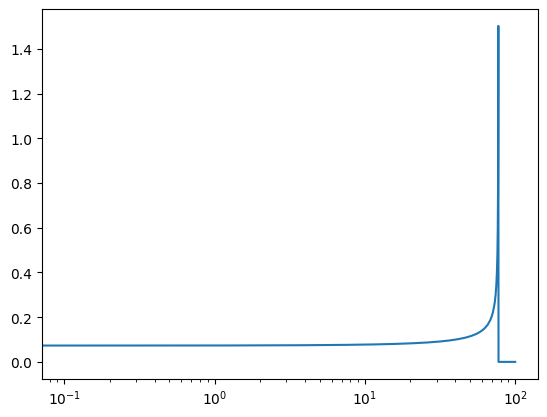

In [ ]:
def simulate_range(Ek, dedx_callable, steps=20000, dx=10):
  ## Copy the initial values of the kinetic energy Ek in a local copy
  Ek = np.asarray(Ek).copy()

  ## Creates an empty list to store the deposited energy at each step
  deposited_energy = []

  for step in range(steps):
    ## Compute the energy loss
    dedx = dedx_callable(Ek)
    ## Correct the energy per the energy loss (0.1 is there to convert from cm^-1 to mm-1)
    next_Ek = np.maximum(0, Ek - dedx*0.1*dx)
    ## Store the deposited energy (- energy loss) in the deposited_energy list
    deposited_energy.append( -(next_Ek - Ek) )
    ## Update the values of the kinetic energy
    Ek = next_Ek

  ## Transform the list into an array
  return np.arange(steps)*dx, np.array(deposited_energy)


## Example call
depth_axis, deposited_energy = simulate_range(
    Ek=100,
    dedx_callable=get_dedx_proton,
    steps=1000,
    dx=0.1
    )

plt.plot(depth_axis, deposited_energy)
plt.xscale('log')
plt.show()

## Esercizio 3.1
Usando la funzione `simulate_range` definita qui sopra, si determinino i valori di `dx` e `steps` che consentano di trattare correttamente particelle nel range di energia cinetica tra 100 MeV/$c^2$ e 50 GeV/$c^2$.

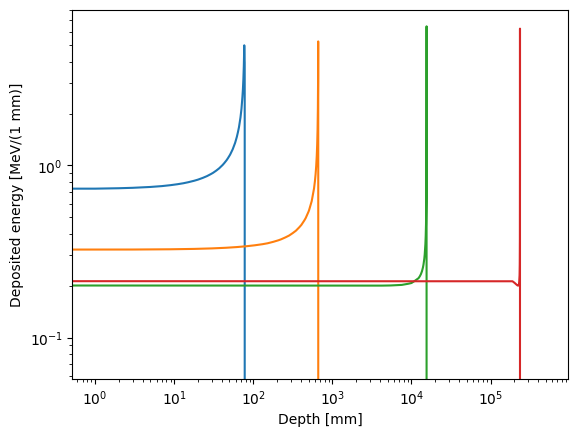

In [ ]:
Ek = np.array([100, 350, 3500, 50000])
dx = 1
steps = 500_000

xAxis, deposited_energy = simulate_range(Ek, dedx_callable=get_dedx_proton, steps=steps, dx=dx)

plt.plot(xAxis, deposited_energy)
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Depth [mm]")
plt.ylabel(f'Deposited energy [MeV/({dx} mm)]')
plt.show()

## Esercizio 3.2

Utilizzando i valori `dx` e `steps` dell'esercizio precedente, si costruisca una funzione analoga a `simulate_range` che simuli però l'emissione Cherenkov in acqua di un elettrone o di un protone in funzione della loro energia cinetica.

Il plot atteso assomiglia al seguente.


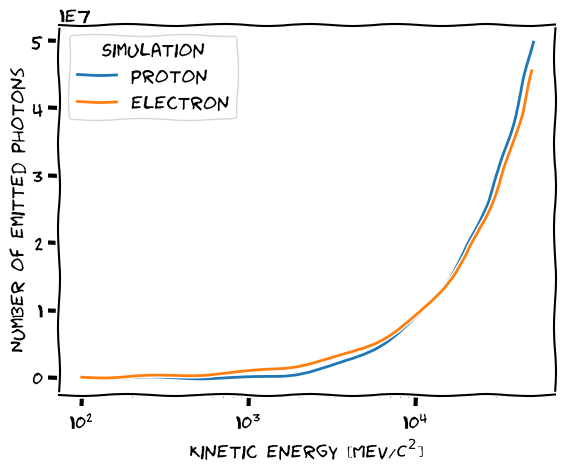

<ipython-input-51-1f4fcfa93239>:5: RuntimeWarning: divide by zero encountered in true_divide
  dndwl = np.maximum(0, 2*np.pi/137/wl**2 * (1 - 1/(beta[:,None]*get_n(wl))**2))


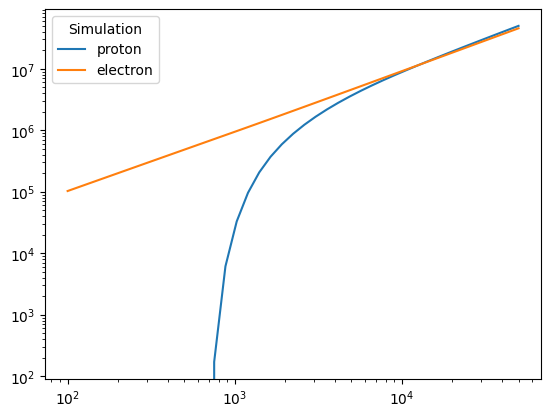

In [ ]:
## Soluzione

def simulate_cherenkov(Ek, mass, dedx_callable, steps=500_000, dx=1):
  Ek = Ek.copy()
  n_ph = []
  for step in range(steps):
    gamma = np.sqrt((Ek**2 + mass**2))/mass
    beta = np.sqrt(1 - 1/gamma**2)
    dedx = dedx_callable(Ek)
    Ek = np.maximum(0, Ek - dedx*0.1*dx)
    photons_per_mm = count_photons_per_micron(beta)*1000
    n_ph.append(photons_per_mm * dx)

  return sum(n_ph)

pE_axis = np.exp(np.linspace(np.log(100), np.log(50000), 41))
n_ph_proton = simulate_cherenkov(pE_axis, mass=938, dedx_callable=get_dedx_proton)
n_ph_electron = simulate_cherenkov(pE_axis, mass=0.5, dedx_callable=get_dedx_electron)

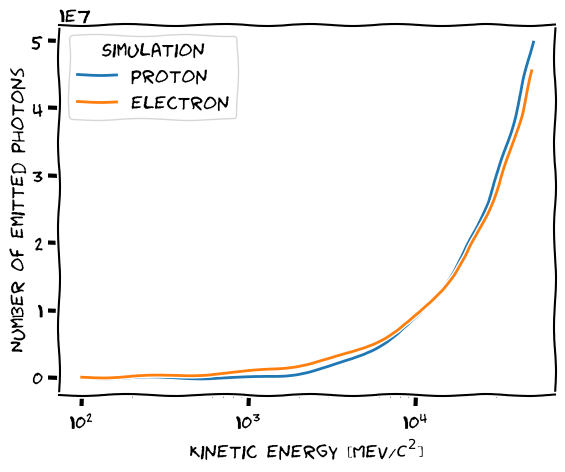

In [ ]:
## Soluzione
plt.plot(pE_axis, n_ph_proton, label="proton")
plt.plot(pE_axis, n_ph_electron, label="electron")
plt.legend(title="Simulation")
plt.xscale('log')
plt.xlabel("Kinetic energy [MeV/$c^2$]")
plt.ylabel("Number of emitted photons")
plt.yscale('linear')
plt.show()

## Conclusione

In questo esercizio abbiamo discusso un semplice modello per descrivere l'emissione di luce Cherenkov in acqua da parte di particelle cariche e stabili, concentrandoci in particolare sul caso di elettrone e protone.
Questi studi, ovviamente raffinati e approfonditi, sono necessari per gli studi dei raggi cosmici con gli esperimenti marini, che utilizzando grandi volumi di acqua marina per rilevare interazioni rare.

Il risultato di queste interazioni è l'emissione di un elettrone o di un protone in acqua che emette luce Cherenkov che viene rilevata con fototubi.

Altre applicazioni di questi studi riguardano gli esperimenti per neutrini come Kamiokande e Super-Kamiokande in cui grandi volumi di acqua pura sono racchiusi un contenitore ricoperto di fototubi per rilevare l'interazione di neutrini con l'acqua, con lo stesso meccanismo discusso sopra.
